In [1]:
import pyspark
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [2]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [3]:
sqlc

In [4]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'wz8nx/fastfood.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)

,storenum,secs,dayofweek,meal,drinkonly,cost,satisfaction
0,76,119,Tues,Dinner,No,773,8
1,127,135,Mon,Dinner,Yes,149,6
2,777,105,Thur,Lunch,No,416,8
3,445,144,Mon,Lunch,Yes,191,7
4,493,82,Thur,Breakfast,No,242,6
5,822,268,Tues,Dinner,Yes,161,6
6,640,151,Mon,Lunch,No,261,5
7,365,60,Fri,Lunch,No,265,7
8,661,175,Wed,Dinner,No,747,6
9,607,151,Mon,Lunch,No,430,5


In [5]:
df = sqlc.createDataFrame(pd.read_csv(data_location))

In [6]:
df

DataFrame[storenum: bigint, secs: bigint, dayofweek: string, meal: string, drinkonly: string, cost: bigint, satisfaction: bigint]

In [8]:
parquetPath = '/home/ec2-user/SageMaker/wz8nx-pqt'
df.write.parquet(parquetPath)

In [9]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "wz8nx/wz8nx-pqt/"+f)

In [10]:
df = sqlc.read.parquet(parquetPath)

In [11]:
df

DataFrame[storenum: bigint, secs: bigint, dayofweek: string, meal: string, drinkonly: string, cost: bigint, satisfaction: bigint]

In [12]:
# setup dataframe
bucket = 'odl-spark19spds6003-001'
data_key = 'wz8nx/fastfood.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)

In [13]:
pddf = pddf.dropna()

In [14]:
df = sqlc.createDataFrame(pddf)

In [15]:
display(df)

DataFrame[storenum: bigint, secs: bigint, dayofweek: string, meal: string, drinkonly: string, cost: bigint, satisfaction: bigint]

In [16]:
df.printSchema()

root
 |-- storenum: long (nullable = true)
 |-- secs: long (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- meal: string (nullable = true)
 |-- drinkonly: string (nullable = true)
 |-- cost: long (nullable = true)
 |-- satisfaction: long (nullable = true)



In [17]:
df.take(5)

[Row(storenum=76, secs=119, dayofweek='Tues', meal='Dinner', drinkonly='No', cost=773, satisfaction=8),
 Row(storenum=127, secs=135, dayofweek='Mon', meal='Dinner', drinkonly='Yes', cost=149, satisfaction=6),
 Row(storenum=777, secs=105, dayofweek='Thur', meal='Lunch', drinkonly='No', cost=416, satisfaction=8),
 Row(storenum=445, secs=144, dayofweek='Mon', meal='Lunch', drinkonly='Yes', cost=191, satisfaction=7),
 Row(storenum=493, secs=82, dayofweek='Thur', meal='Breakfast', drinkonly='No', cost=242, satisfaction=6)]

In [18]:
print("Pearson's r(cost,satisfaction) = {}".format(df.corr("cost", "satisfaction")))
print("Pearson's r(secs,satisfaction) = {}".format(df.corr("secs", "satisfaction")))
print("Pearson's r(storenum,satisfaction) = {}".format(df.corr("storenum", "satisfaction")))

Pearson's r(cost,satisfaction) = 0.23782059836118996
Pearson's r(secs,satisfaction) = -0.5014401859166516
Pearson's r(storenum,satisfaction) = 0.0018368387413620413


In [19]:
from pyspark.sql.functions import log
from pyspark.sql.functions import col

In [20]:
df = df.withColumn('logC', log("cost"))
df.printSchema()

root
 |-- storenum: long (nullable = true)
 |-- secs: long (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- meal: string (nullable = true)
 |-- drinkonly: string (nullable = true)
 |-- cost: long (nullable = true)
 |-- satisfaction: long (nullable = true)
 |-- logC: double (nullable = true)



In [21]:
df.drop("cost")

DataFrame[storenum: bigint, secs: bigint, dayofweek: string, meal: string, drinkonly: string, satisfaction: bigint, logC: double]

In [22]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 71815, test set N = 17977


In [23]:
from pyspark.ml.linalg import Vectors, VectorUDT

In [24]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("logC", "oneElementVec(satisfaction) as satisfaction")
testDF = testDF.selectExpr("logC", "oneElementVec(satisfaction) as satisfaction")

print(testDF.orderBy(testDF.logC.desc()).limit(5))

DataFrame[logC: double, satisfaction: vector]


In [25]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("logC", "label").withColumnRenamed("satisfaction", "features")
testDF = testDF.withColumnRenamed("logC", "label").withColumnRenamed("satisfaction", "features")

In [26]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [27]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [28]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=6.720220155135295, features=DenseVector([5.0]), prediction=5.8090196662484415), Row(label=6.720220155135295, features=DenseVector([9.0]), prediction=6.130465643386769), Row(label=6.720220155135295, features=DenseVector([8.0]), prediction=6.050104149102188), Row(label=6.720220155135295, features=DenseVector([6.0]), prediction=5.8893811605330235), Row(label=6.720220155135295, features=DenseVector([7.0]), prediction=5.969742654817606)]


In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [30]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [31]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

0.5061632997230543

In [32]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.05069701369066526

In [33]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [34]:
x = df.toPandas()['logC']
y = df.toPandas()['satisfaction']

Text(0.5,1,'Distribution of Satisfaction')

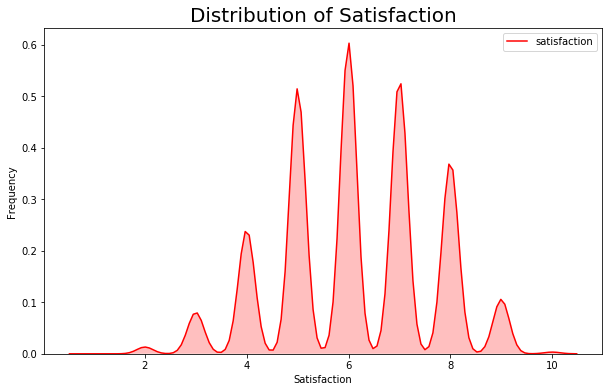

In [35]:
import seaborn as sns
plt.figure(figsize=(10,6))
rewviews = sns.kdeplot(y, color="Red", shade = True)
rewviews.set_xlabel("Satisfaction")
rewviews.set_ylabel("Frequency")
plt.title('Distribution of Satisfaction',size = 20)

Text(0.5,1,'Distribution of Log of Cost')

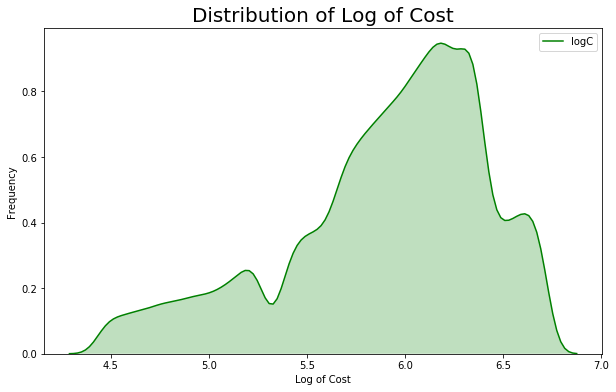

In [36]:
plt.figure(figsize=(10,6))
rewviews = sns.kdeplot(x, color="green", shade = True)
rewviews.set_xlabel("Log of Cost")
rewviews.set_ylabel("Frequency")
plt.title('Distribution of Log of Cost',size = 20)

In [62]:
z = pd.DataFrame(x,y)
z = z.reset_index()
z.columns = ['logC','satisfaction']

In [63]:
import numpy as np
result = z.groupby(["satisfaction"])['logC'].aggregate(np.mean).reset_index()

Text(0.5,1,'Log of Cost vs Satisfaction')

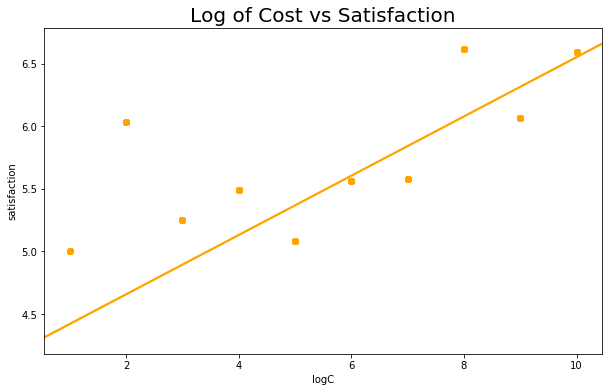

In [65]:
plt.figure(figsize = (10,6))
sns.regplot(x="logC", y="satisfaction", color = 'Orange',data = z);
plt.title('Log of Cost vs Satisfaction',size = 20)